In [1]:
%pylab inline
import jax
import jax.numpy as np
%load_ext autoreload
%autoreload 2

import vbjax

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
** shtns is not available


## Montbrio-Pazo-Roxin

Let's take the MPR model as an example, with an end goal of fitting some EEG style spectra.

In [3]:
x0 = np.zeros((2, 32))
vbjax.mpr_dfun(x0, c=[1., 0.], p=vbjax.mpr_default_theta).shape

(2, 32)

so our dfun will automatically make use of vectors for state space, let's build a network model, just by composing a coupling function with the Jansen-Rit dfun

In [8]:
nn = 32
ns = np.tile(np.arange(nn),(nn,1))
key = jax.random.PRNGKey(42)
weights = jax.random.normal (key, (nn, nn))
lengths = jax.random.randint(key, (nn, nn), 0, 255)

def net_dfun(x, p):
    w, l, mass_θ = p
    return vbjax.mpr_dfun(x, x[0], mass_θ)

x0 = np.zeros((2, nn))
net_θ = weights, lengths, vbjax.mpr_default_theta
net_dfun(x0, net_θ).shape

(2, 32)

In [21]:
vbjax.mpr_default_theta

MPRTheta(tau=1.0, I=0.0, Delta=1.0, J=15.0, eta=-5.0, cr=1.0, cv=0.0)

now do a simulation,

In [36]:
step, loop = vbjax.make_sde(0.01, net_dfun, 1e-1)

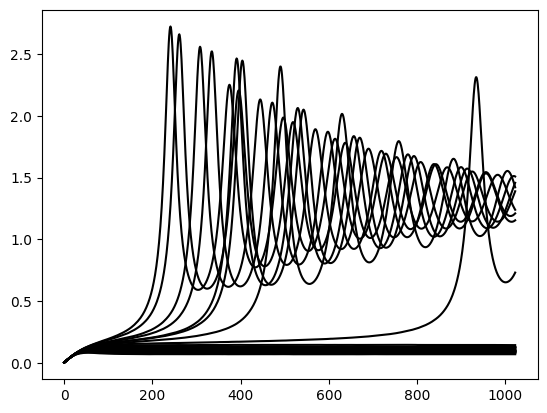

In [37]:
key = jax.random.PRNGKey(0)
nt = 1024
x0 = np.zeros((2, nn))
zt = jax.random.normal(key, (nt, ) + x0.shape) * 1e-2
I = jax.random.normal(key, shape=(nn, ))+1.0
net_θ = weights, lengths, vbjax.mpr_default_theta._replace(
    eta=-4.7,
    I=I)
yt = loop(x0, zt, net_θ)
r, v = yt.transpose((1, 0, 2))
plot(r, 'k');

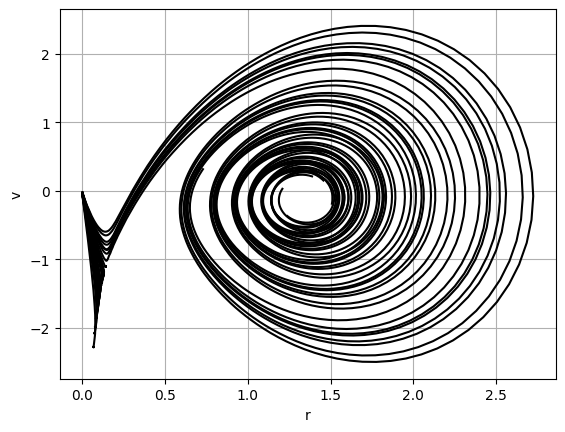

In [38]:
plot(r, v, 'k'); xlabel('r'), ylabel('v'); grid(1)

In [6]:
%timeit loop(x0, zt, net_θ)

155 µs ± 319 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
